# Linear Support Vector Classifier

In [1]:
# Install packages
%pip install -q -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Load data into a dataset
df = pd.read_csv("mbit_preprocessed_features.csv", index_col=0)
display(df.head())

,type,posts,encodedType,preprocessed_posts,extro_intro,intu_obs,feel_think,prosp_judg,avg_word_count,avg_exclam_count,avg_fullstop_count,avg_emoji_count,avg_count_of_hello,avg_count_of_hi,avg_count_of_extroverted_bigrams,avg_count_of_extroverted_stylistic_impressions,avg_count_of_interoverted_quantifiers,avg_count_of_introverted_first_person_singular_pronoun,avg_count_of_introverted_negations
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,8,"['youtube', 'tumblr', 'enfp', 'intj', 'moment'...",0,1,1,0,12.10,0.0,0.16,0.08,0.0,0.0,0.14,0.0,0.06,3.54,0.02
1,ENTP,'I'm finding the lack of me in these posts ver...,3,"['im', 'finding', 'the', 'lack', 'of', 'post',...",1,1,0,1,24.38,0.0,0.04,0.08,0.0,0.0,0.28,0.0,0.14,5.58,0.10
2,INTP,'Good one _____ https://www.youtube.com/wat...,11,"['good', 'one', 'youtube', 'of', 'course', 'i'...",0,1,0,1,17.70,0.0,0.08,0.00,0.0,0.0,0.26,0.0,0.00,5.18,0.04
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",10,"['dear', 'intp', 'i', 'enjoyed', 'conversation...",0,1,0,0,22.26,0.0,0.14,0.02,0.0,0.0,0.20,0.0,0.10,6.12,0.10
4,ENTJ,'You're fired.|||That's another silly misconce...,2,"['youre', 'fired', 'thats', 'another', 'silly'...",1,1,0,0,20.32,0.0,0.08,0.06,0.0,0.0,0.14,0.0,0.00,6.10,0.10


In [4]:
# Create the train/test split
def create_train_test_split(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42069)
    return X_train, X_test, Y_train, Y_test

# Plot the confusion matrix (copied from Exercise 3)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [5]:
# Loads input data from dataset and vectorizes it
X = df.iloc[:, 3].values #Preprocessed_posts

# Create vectorizer
vectorizer = TfidfVectorizer()
matrix = vectorizer.fit_transform(X)
X = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Add features
scaler = preprocessing.MinMaxScaler()
X['avg_word_count'] = df.iloc[:, 8].values
X['avg_exclam_count'] = df.iloc[:, 9].values
X['avg_fullstop_count'] = df.iloc[:, 10].values
X['avg_emoji_count'] = df.iloc[:, 11].values
X['avg_count_of_hello'] = df.iloc[:, 12].values
X['avg_count_of_hi'] = df.iloc[:, 13].values
X['avg_count_of_extroverted_bigrams'] = df.iloc[:, 14].values
X['avg_count_of_extroverted_stylistic_impressions'] = df.iloc[:, 15].values
X['avg_count_of_interoverted_quantifiers'] = df.iloc[:, 16].values
X['avg_count_of_introverted_first_person_singular_pronoun'] = df.iloc[:, 17].values
X['avg_count_of_introverted_negations'] = df.iloc[:, 18].values

X[['avg_word_count', 'avg_count_of_introverted_first_person_singular_pronoun']] = scaler.fit_transform(
    X[['avg_word_count', 'avg_count_of_introverted_first_person_singular_pronoun']])

print("Vectorizer created {} features.".format(len(vectorizer.get_feature_names_out())))

Vectorizer created 140798 features.


In [6]:
# Get actual types of test data
Y_multi = df.iloc[:, 2].values
X_train, X_test, Y_train, Y_test_basis = train_test_split(X, Y_multi, test_size=0.3, random_state=42069)
types = sorted(list(set(df.iloc[:, 0].values)))

def combine_evaluate(intro, sensi, think, judgi):
    # Create dataframe
    df1 = df[['encodedType', 'extro_intro', 'intu_obs', 'feel_think', 'prosp_judg']].drop_duplicates().reset_index(drop=True)

    predict_df = pd.DataFrame(np.transpose([intro, sensi, think, judgi]), 
                             columns =['extro_intro', 'intu_obs', 'feel_think', 'prosp_judg'])
    predict_df = predict_df.merge(df1, how = 'left', on = predict_df.columns.tolist())
    
    # Evaluate
    print("Classification Report:")
    print(classification_report(Y_test_basis, predict_df['encodedType'], target_names=types, zero_division=0))

    cnf_matrix = confusion_matrix(Y_test_basis, predict_df['encodedType'])
    np.set_printoptions(precision=2)
    plot_confusion_matrix(cnf_matrix, classes=types)

### Gridsearch

In [5]:
Y = df.iloc[:, 4].values # Introverted-Extroverted

X_train, X_test, Y_train, Y_test = create_train_test_split(X, Y)

parameters = {       
'penalty': ['l1', 'l2'],
'loss': ['hinge', 'squared_hinge'],
'dual': [True, False],
}

estimator = LinearSVC()

stratified_3_fold_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search_estimator = GridSearchCV(estimator, parameters, scoring='accuracy', cv=stratified_3_fold_cv)

grid_search_estimator.fit(X_train, Y_train)
display(grid_search_estimator.best_params_)

C:\Users\AGANDO\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
12 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\AGANDO\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\AGANDO\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "C:\Users\AGANDO\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1204, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_

{'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'}

In [7]:
Y_intro = df.iloc[:, 4].values
Y_sensi = df.iloc[:, 5].values
Y_think = df.iloc[:, 6].values
Y_judgi = df.iloc[:, 7].values

# Train the model and print the classification report (modified)
def train_predict_model(X, Y, types, balancing, found_parameters):
    X_train, X_test, Y_train, Y_test = create_train_test_split(X, Y)
    
    if (balancing):
        sampler = RandomOverSampler()
        X_train, Y_train = sampler.fit_resample(X_train, Y_train)
    
    # Train the model
    estimator = LinearSVC()
    if (found_parameters):
        estimator = LinearSVC(penalty='l1', dual=False)
    
    estimator.fit(X_train, Y_train)
    
    # Prediction
    predicted = estimator.predict(X_test)
    
    # Evaluation
    print("Classification Report:")
    print(classification_report(Y_test, predicted, target_names=types, zero_division=0))
    
    cnf_matrix = confusion_matrix(Y_test, predicted)
    np.set_printoptions(precision=2)
    plot_confusion_matrix(cnf_matrix, classes=types)
        
    return predicted

# Binary models (unbalanced, found parameters)

### Binary model: Introverted-Extroverted

/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

 Introverted       0.87      0.94      0.91      2002
 Extroverted       0.75      0.55      0.63       601

    accuracy                           0.85      2603
   macro avg       0.81      0.75      0.77      2603
weighted avg       0.85      0.85      0.84      2603



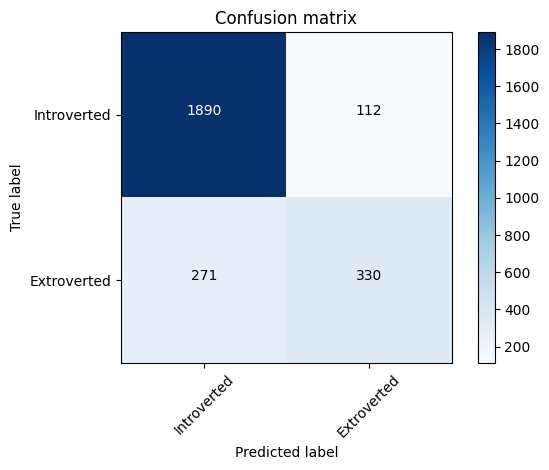

In [8]:
# Binary: Introverted-Extroverted
predicted_intro = train_predict_model(X, Y_intro, ['Introverted', 'Extroverted'], False, True)

### Binary model: Sensing-Intuition

/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

     Sensing       0.78      0.42      0.55       342
   Intuition       0.92      0.98      0.95      2261

    accuracy                           0.91      2603
   macro avg       0.85      0.70      0.75      2603
weighted avg       0.90      0.91      0.90      2603



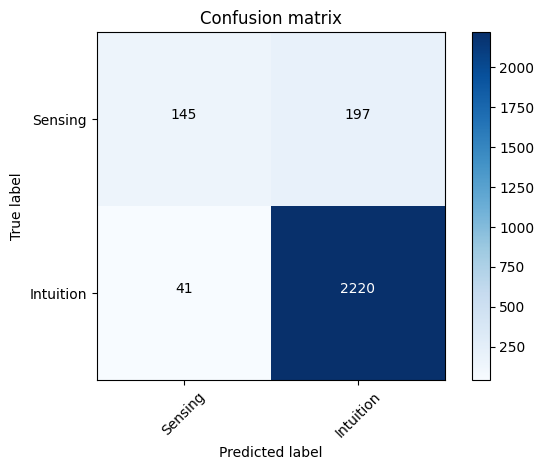

In [9]:
# Binary: Sensing-Intuition
predicted_sensi = train_predict_model(X, Y_sensi, ['Sensing', 'Intuition'], False, True)

### Binary model: Thinking-Feeling

Classification Report:
              precision    recall  f1-score   support

    Thinking       0.84      0.82      0.83      1199
     Feeling       0.85      0.87      0.86      1404

    accuracy                           0.85      2603
   macro avg       0.85      0.85      0.85      2603
weighted avg       0.85      0.85      0.85      2603



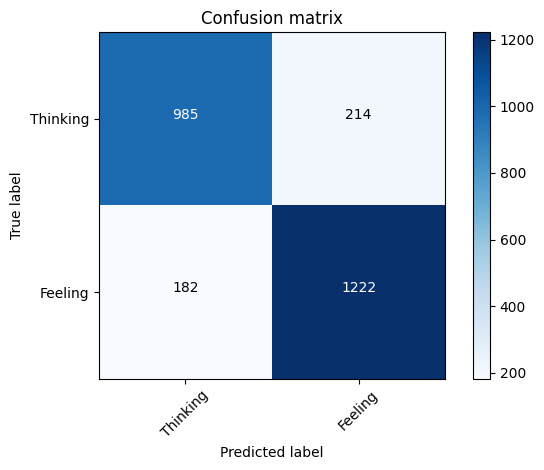

In [10]:
# Binary: Thinking-Feeling
predicted_think = train_predict_model(X, Y_think, ['Thinking', 'Feeling'], False, True)

### Binary model: Judging-Perceiving

Classification Report:
              precision    recall  f1-score   support

     Judging       0.78      0.64      0.70      1071
  Perceiving       0.78      0.87      0.82      1532

    accuracy                           0.78      2603
   macro avg       0.78      0.76      0.76      2603
weighted avg       0.78      0.78      0.77      2603



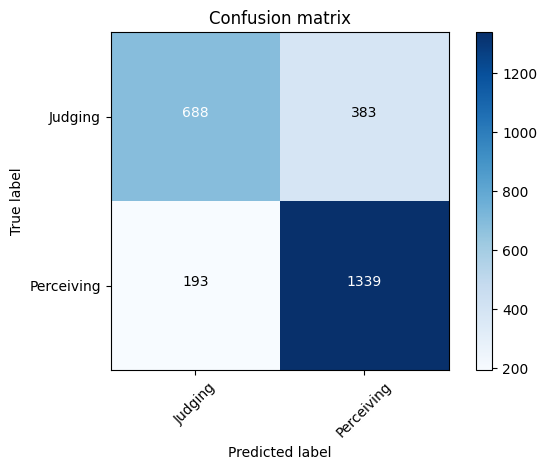

In [11]:
# Judging-Perceiving
predicted_judgi = train_predict_model(X, Y_judgi, ['Judging', 'Perceiving'], False, True)

### Estimating MBTI

Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.15      0.15      0.15        55
        ENFP       0.63      0.50      0.56       212
        ENTJ       0.35      0.23      0.28        74
        ENTP       0.59      0.46      0.52       196
        ESFJ       0.00      0.00      0.00        11
        ESFP       0.20      0.07      0.11        14
        ESTJ       0.25      0.09      0.13        11
        ESTP       0.25      0.04      0.06        28
        INFJ       0.65      0.55      0.60       436
        INFP       0.57      0.79      0.67       545
        INTJ       0.58      0.53      0.55       365
        INTP       0.50      0.72      0.59       378
        ISFJ       0.50      0.41      0.45        58
        ISFP       0.43      0.26      0.32        73
        ISTJ       0.56      0.25      0.34        61
        ISTP       0.57      0.33      0.41        86

    accuracy                           0.56      2603
   

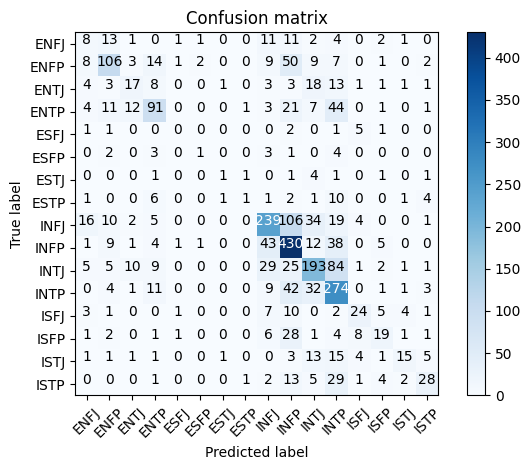

In [12]:
combine_evaluate(predicted_intro, predicted_sensi, predicted_think, predicted_judgi)

# Binary models (balanced, default parameters)

### Binary model: Introverted-Extroverted

Classification Report:
              precision    recall  f1-score   support

 Introverted       0.89      0.92      0.91      2002
 Extroverted       0.70      0.64      0.67       601

    accuracy                           0.85      2603
   macro avg       0.80      0.78      0.79      2603
weighted avg       0.85      0.85      0.85      2603



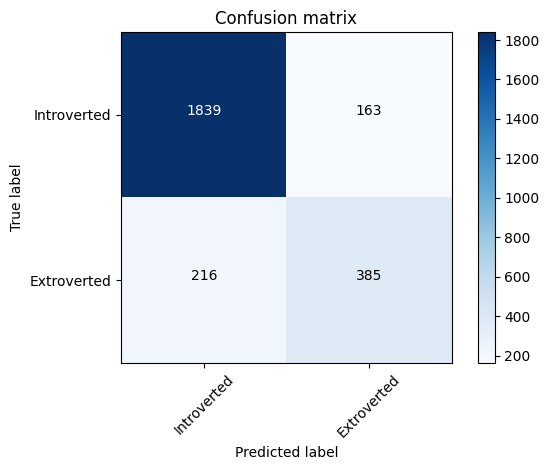

In [13]:
# Binary: Introverted-Extroverted
predicted_intro = train_predict_model(X, Y_intro, ['Introverted', 'Extroverted'], True, False)

### Binary model: Sensing-Intuition

Classification Report:
              precision    recall  f1-score   support

     Sensing       0.69      0.54      0.61       342
   Intuition       0.93      0.96      0.95      2261

    accuracy                           0.91      2603
   macro avg       0.81      0.75      0.78      2603
weighted avg       0.90      0.91      0.90      2603



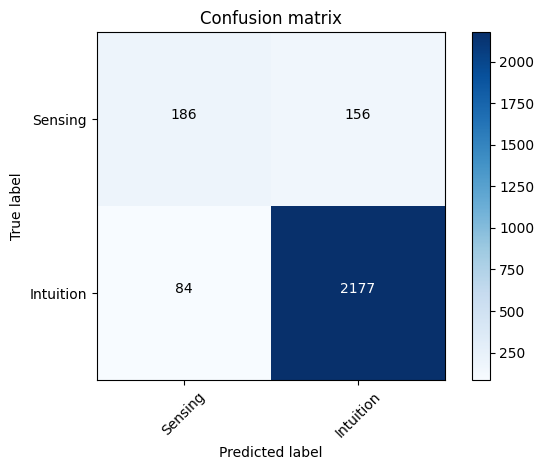

In [14]:
# Binary: Sensing-Intuition
predicted_sensi = train_predict_model(X, Y_sensi, ['Sensing', 'Intuition'], True, False)

### Binary model: Thinking-Feeling

Classification Report:
              precision    recall  f1-score   support

    Thinking       0.83      0.83      0.83      1199
     Feeling       0.86      0.86      0.86      1404

    accuracy                           0.85      2603
   macro avg       0.85      0.85      0.85      2603
weighted avg       0.85      0.85      0.85      2603



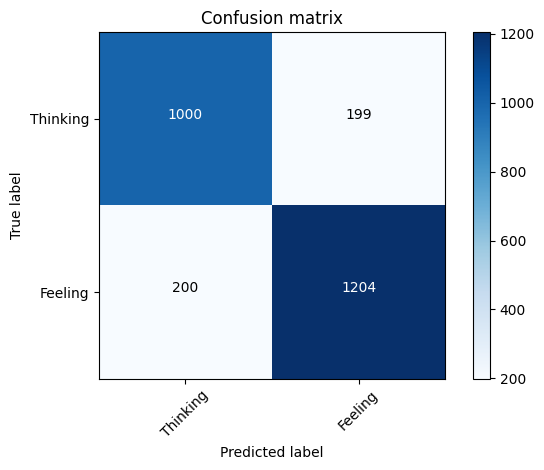

In [15]:
# Binary: Thinking-Feeling
predicted_think = train_predict_model(X, Y_think, ['Thinking', 'Feeling'], True, False)

### Binary model: Judging-Perceiving

Classification Report:
              precision    recall  f1-score   support

     Judging       0.76      0.68      0.72      1071
  Perceiving       0.79      0.85      0.82      1532

    accuracy                           0.78      2603
   macro avg       0.78      0.77      0.77      2603
weighted avg       0.78      0.78      0.78      2603



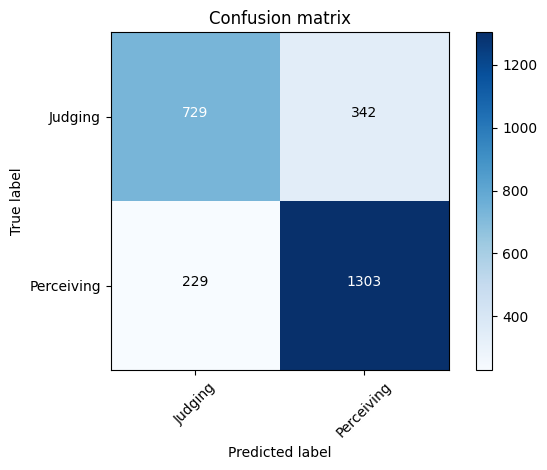

In [16]:
# Judging-Perceiving
predicted_judgi = train_predict_model(X, Y_judgi, ['Judging', 'Perceiving'], True, False)

### Estimating MBTI

Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.16      0.18      0.17        55
        ENFP       0.60      0.51      0.55       212
        ENTJ       0.28      0.26      0.27        74
        ENTP       0.56      0.54      0.55       196
        ESFJ       0.30      0.27      0.29        11
        ESFP       0.00      0.00      0.00        14
        ESTJ       0.22      0.18      0.20        11
        ESTP       0.43      0.21      0.29        28
        INFJ       0.65      0.56      0.60       436
        INFP       0.62      0.74      0.68       545
        INTJ       0.56      0.53      0.54       365
        INTP       0.53      0.66      0.59       378
        ISFJ       0.50      0.48      0.49        58
        ISFP       0.42      0.32      0.36        73
        ISTJ       0.42      0.25      0.31        61
        ISTP       0.51      0.45      0.48        86

    accuracy                           0.56      2603
   

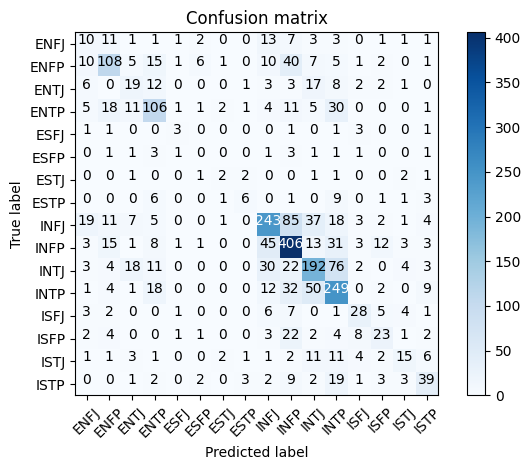

In [17]:
combine_evaluate(predicted_intro, predicted_sensi, predicted_think, predicted_judgi)

# Binary models (balanced, found parameters)

### Binary model: Introverted-Extroverted

/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

 Introverted       0.90      0.87      0.89      2002
 Extroverted       0.61      0.66      0.64       601

    accuracy                           0.83      2603
   macro avg       0.75      0.77      0.76      2603
weighted avg       0.83      0.83      0.83      2603



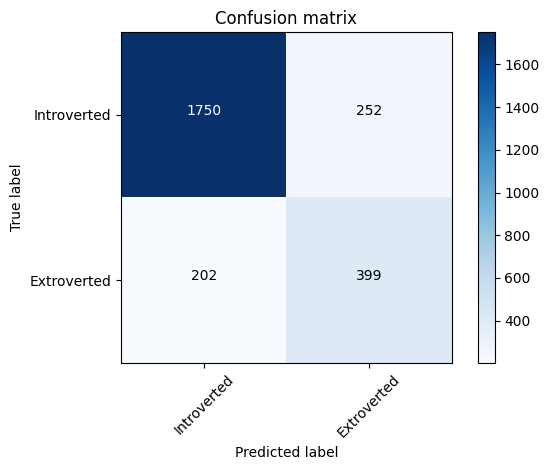

In [18]:
# Binary: Introverted-Extroverted
predicted_intro = train_predict_model(X, Y_intro, ['Introverted', 'Extroverted'], True, True)

### Binary model: Sensing-Intuition

/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

     Sensing       0.54      0.64      0.58       342
   Intuition       0.94      0.92      0.93      2261

    accuracy                           0.88      2603
   macro avg       0.74      0.78      0.76      2603
weighted avg       0.89      0.88      0.88      2603



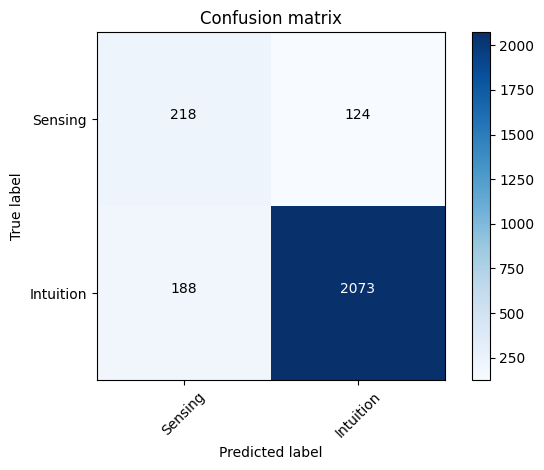

In [19]:
# Binary: Sensing-Intuition
predicted_sensi = train_predict_model(X, Y_sensi, ['Sensing', 'Intuition'], True, True)

### Binary model: Thinking-Feeling

Classification Report:
              precision    recall  f1-score   support

    Thinking       0.83      0.83      0.83      1199
     Feeling       0.85      0.86      0.86      1404

    accuracy                           0.84      2603
   macro avg       0.84      0.84      0.84      2603
weighted avg       0.84      0.84      0.84      2603



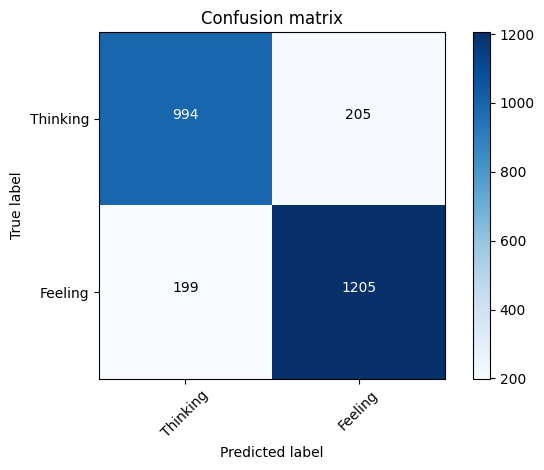

In [20]:
# Binary: Thinking-Feeling
predicted_think = train_predict_model(X, Y_think, ['Thinking', 'Feeling'], True, True)

### Binary model: Judging-Perceiving

Classification Report:
              precision    recall  f1-score   support

     Judging       0.73      0.70      0.72      1071
  Perceiving       0.80      0.82      0.81      1532

    accuracy                           0.77      2603
   macro avg       0.77      0.76      0.76      2603
weighted avg       0.77      0.77      0.77      2603



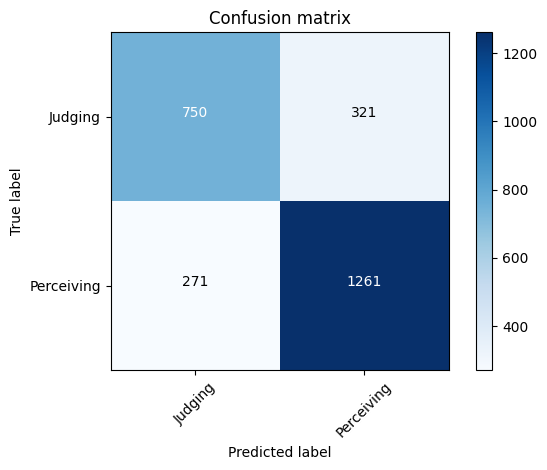

In [21]:
# Judging-Perceiving
predicted_judgi = train_predict_model(X, Y_judgi, ['Judging', 'Perceiving'], True, True)

### Estimating MBTI

Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.16      0.25      0.20        55
        ENFP       0.53      0.52      0.53       212
        ENTJ       0.22      0.27      0.25        74
        ENTP       0.50      0.47      0.49       196
        ESFJ       0.17      0.27      0.21        11
        ESFP       0.00      0.00      0.00        14
        ESTJ       0.13      0.18      0.15        11
        ESTP       0.17      0.18      0.17        28
        INFJ       0.64      0.51      0.57       436
        INFP       0.65      0.68      0.66       545
        INTJ       0.57      0.50      0.54       365
        INTP       0.57      0.59      0.58       378
        ISFJ       0.34      0.45      0.39        58
        ISFP       0.26      0.30      0.28        73
        ISTJ       0.30      0.34      0.32        61
        ISTP       0.39      0.42      0.40        86

    accuracy                           0.52      2603
   

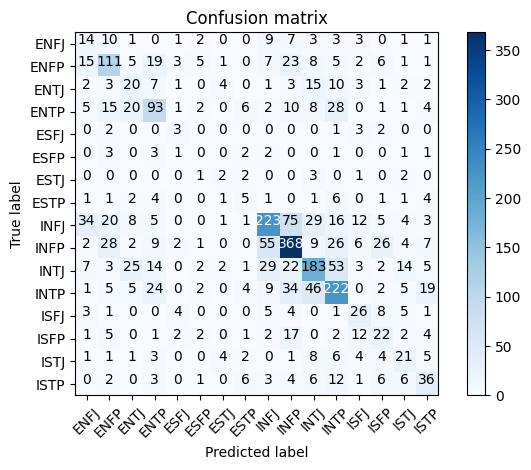

In [22]:
combine_evaluate(predicted_intro, predicted_sensi, predicted_think, predicted_judgi)